In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
import pandas
import numpy as np

In [0]:
#!wget https://storage.googleapis.com/kaggle-forum-message-attachments/197363/6743/posters.7z

In [0]:
#!apt-get install p7zip-full
#!p7zip -d posters.7z

^C
/usr/bin/p7zip: cannot read posters.7z


In [3]:
#This data source has 848 zero bytes poster files
#remove these files and corresponding genre
!find "./posters" -size 0 -print | tail

./posters/97109.jpg
./posters/972385.jpg
./posters/97607.jpg
./posters/977611.jpg
./posters/979953.jpg
./posters/98208.jpg
./posters/982851.jpg
./posters/98343.jpg
./posters/98624.jpg
./posters/996957.jpg


In [0]:
zero_files = !find "./posters" -size 0 -print | cut -d'/' -f3 | cut -d'.' -f1

In [5]:
zero_files[:5]

['1002581', '1010054', '1013528', '1013746', '102336']

Get the poster-genere.csv file 

In [0]:
#!rm -rf MovieGenre
!git clone https://github.com/vinpBlr/MovieGenre.git

Cloning into 'MovieGenre'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 5), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
!ls

MovieGenre  posters  sample_data  tmp


In [0]:
poster_genre = pd.read_csv('MovieGenre/poster_genre.csv')

In [8]:
poster_genre.sample(4)

,image_name,tags
30649,70641,Drama|Thriller
22289,181315,Fantasy|Horror
17770,96841,Drama
29635,3323314,Biography


In [9]:
#remove zero byte files from csv
valid_poster_genre = poster_genre[~poster_genre['image_name'].isin(zero_files)]
valid_poster_genre.shape

(39140, 2)

In [0]:
valid_poster_genre.to_csv('valid_poster_genre.csv', index=False)

In [0]:
#works
#np.random.seed(44)
#databch = (ImageList.from_csv(path='./',csv_name='MovieGenre/poster_genre.csv',folder='posters',suffix='.jpg')
#          .use_partial_data(0.3)
#          .split_by_rand_pct(0.2)
#          )
#databch = databch.label_from_df(cols='tags', label_delim="|")

In [0]:
#works
np.random.seed(44)
databch = (ImageList.from_csv(path='/content',csv_name='valid_poster_genre.csv',folder='posters',suffix='.jpg')
          .use_partial_data(0.3)
          .split_by_rand_pct(0.2)
          )
databch = databch.label_from_df(cols='tags', label_delim="|")

In [0]:
data = databch.transform(get_transforms(),size=128).databunch().normalize(imagenet_stats)

In [23]:
data.c

27

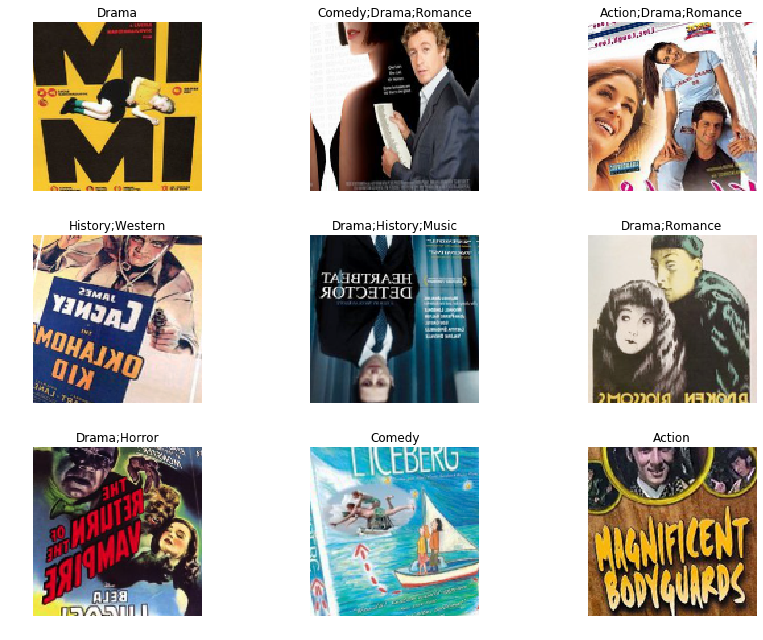

In [14]:
data.show_batch(3, figsize=(12,9))

In [0]:

acc_02 = partial(accuracy_thresh, thresh = 0.3)
f_score = partial(fbeta, thresh = 0.2)


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score], model_dir="tmp/models")


In [17]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.385306,0.214342,0.917692,0.463650,00:47
1,0.224381,0.206628,0.918575,0.488765,00:47
2,0.208877,0.203536,0.918165,0.498108,00:47
3,0.203213,0.202512,0.918780,0.502920,00:47


In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

In [22]:
learn.predict(data.data.valid_dl)
#interp.most_confused(min_val=2)

AttributeError: ignored